In [1]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import csv
import pandas as pd
import h5py
import yt
# Own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p
# from nnc2p import NeuralNetwork # our own architecture
# Get dirs
import os
cwd = os.getcwd()# "Code" folder
master_dir = os.path.abspath(os.path.join(cwd, ".."))

# Introduction

We can run a few simulations in Gmunu. Looking at the .dat files (output from the simulations) is a bit trickier. Hence, we load them here and postprocess/discuss/plot the data in this Python notebook.

# Smooth sine wave

Define the analytic results

In [2]:
A = 0.2
v0 = 0.2
theta = 0.0

def rho_sol_pt(x,y,t):
    return 1.0 + A * np.sin(2.0 * np.pi * ( ( x * np.cos(theta) + y * np.sin(theta) ) - ( v0 * np.cos(theta) ) * t ) )

rho_sol = np.vectorize(rho_sol_pt)

def gamma(field, data):
    return  np.sqrt( 1.0 + (data['W_vel1']**2) )
def veloc1(field, data):
    return data['W_vel1'] / data['gamma']

Read in the Kastaun and neural net sine waves

In [3]:
fname = os.path.join(master_dir, "Data/kastaun_wave.dat")
kastaun_wave = yt.load(fname)
fname = os.path.join(master_dir, "Data/neuralnet_wave.dat")
neuralnet_wave = yt.load(fname)
fname = os.path.join(master_dir, "Data/mock_table_wave.dat")
mock_table_wave = yt.load(fname)

yt : [INFO     ] 2023-05-11 09:34:48,759 Parameters: current_time              = 2.0
yt : [INFO     ] 2023-05-11 09:34:48,762 Parameters: domain_dimensions         = [128   1   1]
yt : [INFO     ] 2023-05-11 09:34:48,794 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-11 09:34:48,796 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-11 09:34:48,798 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-05-11 09:34:48,894 Parameters: current_time              = 2.0
yt : [INFO     ] 2023-05-11 09:34:48,895 Parameters: domain_dimensions         = [128   1   1]
yt : [INFO     ] 2023-05-11 09:34:48,896 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-11 09:34:48,896 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-11 09:34:48,897 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-05-11 09:34:48,976 Parameters: current_time              = 2.0
yt : [INFO     ] 2023

In [4]:
# Final time of simulation 
T_final = float(kastaun_wave.current_time)
# Additional preprocessing - see Gmunu for the source of this
for wave in [kastaun_wave, neuralnet_wave, mock_table_wave]:
    # Add gamma and veloc1
    wave.add_field(('amrvac','gamma'),  function=gamma,  sampling_type='cell')
    wave.add_field(('amrvac','veloc1'), function=veloc1, sampling_type='cell')
# Get the plotdata
plotdata_kastaun   = kastaun_wave.ortho_ray(0, (0, 0))
plotdata_neuralnet = neuralnet_wave.ortho_ray(0, (0, 0))
plotdata_mock_table = mock_table_wave.ortho_ray(0, (0, 0))

yt : [WARNING  ] 2023-05-11 09:35:09,161 e not found and no parfile passed, can not set thermal_pressure.


## Both waves

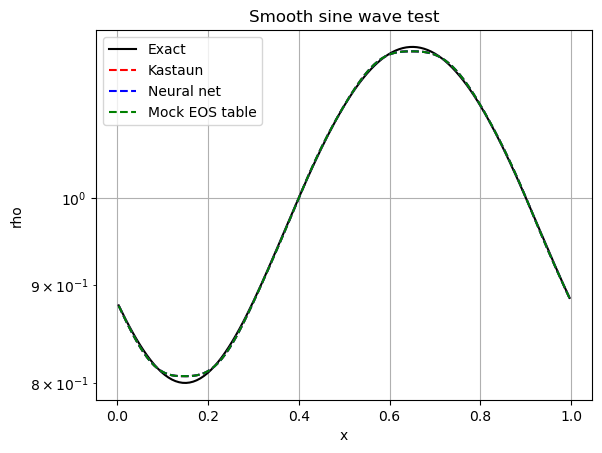

In [5]:
waves = [kastaun_wave, neuralnet_wave, mock_table_wave]
labels = ["Kastaun", "Neural net", "Mock EOS table"]
plotstyles = ["r--", "b--", "g--"]

for i, wave in enumerate(waves):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))

    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    
    # Exact values for this simulation
    if i == 0:
        exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
        plt.plot(np.array(plotdata['x'][srt]), exact_vals, '-', color="black", label="Exact")
    # The approximation
    plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]), plotstyles[i], ms = 2, label=labels[i])

# Differences
# diffs = abs(np.array(plotdata_kastaun['rho'][srt]) - np.array(plotdata_neuralnet['rho'][srt]))
# plt.plot(np.array(plotdata['x'][srt]), diffs, '-', color='black', label = "Difference")

plt.grid()
plt.legend()
plt.xlabel("x")
plt.yscale('log')
plt.ylabel("rho")
plt.title("Smooth sine wave test")
plt.savefig(os.path.join(master_dir, "Plots/smooth_wave_rho_kastaun_neuralnet.pdf"), bbox_inches='tight')
plt.show()

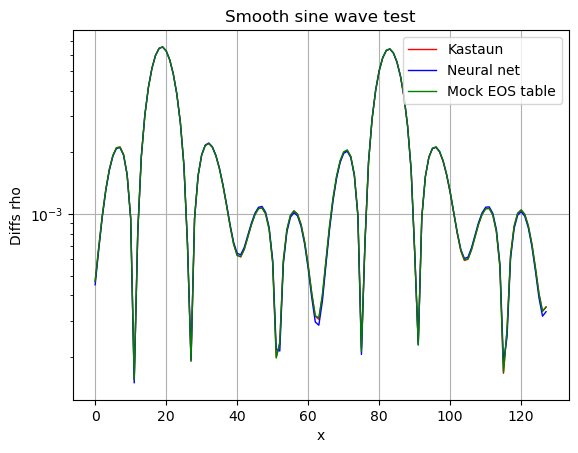

In [6]:
waves = [kastaun_wave, neuralnet_wave, mock_table_wave]
labels = ["Kastaun", "Neural net", "Mock EOS table"]
plotstyles = ["r-", "b-", "g-"]

for i, wave in enumerate(waves):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))

    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    
    # Exact values for this simulation
    exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
    # Difference with numerical solution
    diffs = abs(np.array(plotdata['rho'][srt]) - exact_vals)
    plt.plot(diffs, plotstyles[i], label = labels[i], lw = 1)

plt.grid()
plt.legend()
plt.xlabel("x")
plt.yscale('log')
plt.ylabel("Diffs rho")
plt.title("Smooth sine wave test")
plt.savefig(os.path.join(master_dir, "Plots/smooth_wave_rho_kastaun_neuralnet_diffs.pdf"), bbox_inches='tight')
plt.show()

In [16]:
np.max(diffs)

0.019730106370019262

In [17]:
# plotdata.__dict__.keys()

__TODO__ how to get other entries in the .dat file?

# Shocktube

In [9]:
# Load the datasets
kastaun_shock = yt.load(os.path.join(master_dir, "Data/kastaun_shock.dat"))
kastaun_shock.add_field( ('amrvac','gamma'), function=gamma, sampling_type='cell')
kastaun_shock.add_field( ('amrvac','veloc1'), function=veloc1, sampling_type='cell')

neuralnet_shock = yt.load(os.path.join(master_dir, "Data/neuralnet_shock.dat"))
neuralnet_shock.add_field( ('amrvac','gamma'), function=gamma, sampling_type='cell')
neuralnet_shock.add_field( ('amrvac','veloc1'), function=veloc1, sampling_type='cell')

mock_table_shock = yt.load(os.path.join(master_dir, "Data/mock_table_shock.dat"))
mock_table_shock.add_field( ('amrvac','gamma'), function=gamma, sampling_type='cell')
mock_table_shock.add_field( ('amrvac','veloc1'), function=veloc1, sampling_type='cell')

yt : [INFO     ] 2023-05-11 10:12:45,430 Parameters: current_time              = 0.4
yt : [INFO     ] 2023-05-11 10:12:45,431 Parameters: domain_dimensions         = [16  1  1]
yt : [INFO     ] 2023-05-11 10:12:45,431 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-11 10:12:45,432 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-11 10:12:45,433 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2023-05-11 10:12:45,459 e not found and no parfile passed, can not set thermal_pressure.
yt : [INFO     ] 2023-05-11 10:12:45,644 Parameters: current_time              = 0.4
yt : [INFO     ] 2023-05-11 10:12:45,645 Parameters: domain_dimensions         = [16  1  1]
yt : [INFO     ] 2023-05-11 10:12:45,646 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-11 10:12:45,647 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-11 10:12:45,648 Parameters: cosmological_simulation   = 0
yt : [

Get the data

In [10]:
# cutting the x-axis through the y=0,z=0 
plotdata_kastaun = kastaun_shock.ortho_ray( 0, (0, 0) )
plotdata_neuralnet = neuralnet_shock.ortho_ray( 0, (0, 0) )
plotdata_mock_table = mock_table_shock.ortho_ray( 0, (0, 0) )

# Sort the ray values by 'x' so there are no discontinuities in the line plot
kastaun_srt = np.argsort(plotdata_kastaun['x'])
neuralnet_srt = np.argsort(plotdata_neuralnet['x'])
mock_table_srt = np.argsort(plotdata_mock_table['x'])

Reference:

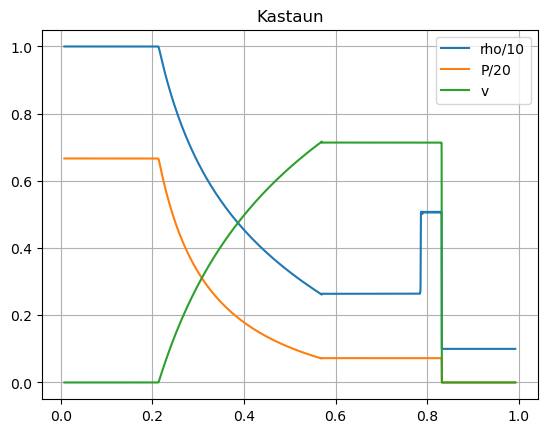

In [18]:
# Plot the data
plotdata = plotdata_kastaun
srt = np.argsort(plotdata['x'])
plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]/10), label='rho/10')
plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['press'][srt]/20), label='P/20')
plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['veloc1'][srt]), label='v')

# Save the line plot
plt.legend(loc='best')
plt.title("Kastaun")
plt.grid()
plt.show()

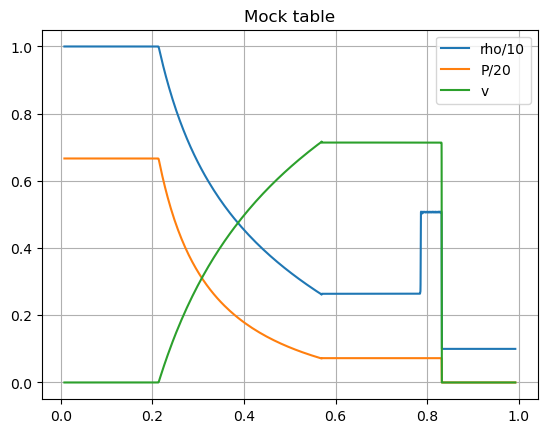

In [19]:
# Plot the data
plotdata = plotdata_mock_table
srt = np.argsort(plotdata['x'])
plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]/10), label='rho/10')
plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['press'][srt]/20), label='P/20')
plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['veloc1'][srt]), label='v')

# Save the line plot
plt.legend(loc='best')
plt.title("Mock table")
plt.grid()
plt.show()